In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds


## Loading and Setting up Data Pipeline

In [ ]:
ds, info = tfds.load("cats_vs_dogs", with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteFVRJOY/cats_vs_dogs-train.tfrecord


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [ ]:
info

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    version=4.0.0,
    description='A large set of images of cats and dogs.There are 1738 corrupted images that are dropped.',
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=23262,
    splits={
        'train': 23262,
    },
    supervised_keys=('image', 'label'),
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
    title = {Asirra: A CAPTCHA that Exploits Interest-Aligned Manual Image Categorization},
    booktitle = {Proceedings of 14th ACM Conference on Computer and Communications Security (CCS)},
    ye

In [ ]:
num_classes = 1

In [ ]:
train_ds = ds["train"]
split_size = 0.3
# test_ds = train_ds.skip()
number_of_imgs = tf.data.experimental.cardinality(train_ds).numpy()
test_ds = train_ds.take(int(split_size*number_of_imgs))
train_ds = train_ds.skip(int(split_size*number_of_imgs))

In [ ]:
number_of_imgs = tf.data.experimental.cardinality(train_ds).numpy()
val_ds = train_ds.take(int(split_size*number_of_imgs))
train_ds = train_ds.skip(int(split_size*number_of_imgs))

In [ ]:
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE
def preprocess(img_info):
  img, label = img_info["image"], img_info["label"]
  # img = tf.cast(img, tf.float32) / 255.
  img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
  return img, label

In [ ]:
train_ds = train_ds.map(preprocess).shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds = val_ds.map(preprocess).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = test_ds.map(preprocess).batch(BATCH_SIZE).prefetch(AUTOTUNE)

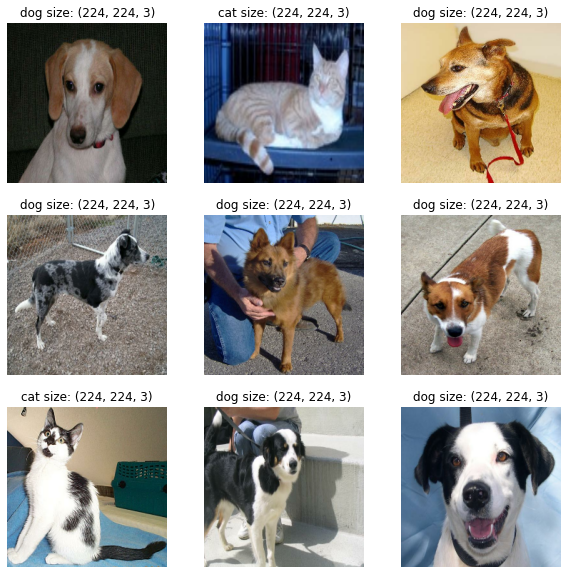

In [ ]:
class_names = ["cat", "dog"]
def show_imgs(data):
  plt.figure(figsize=(10, 10))
  for images, labels in data.take(1):
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(f"{class_names[labels[i]]} size: {images[i].shape}")
      plt.axis("off")

show_imgs(train_ds)

## 3 layer Conv2D

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(256, 3, activation="relu", padding="same", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(62, 3, activation="relu", padding="same"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.5),
    # tf.keras.layers.Flatten()
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=["accuracy"])


In [ ]:
model.fit(train_ds, epochs=30, validation_data=val_ds)

Epoch 1/30
179/179 [==============================] - 128s 470ms/step - loss: 0.6936 - accuracy: 0.5133 - val_loss: 0.6813 - val_accuracy: 0.5713
Epoch 2/30
179/179 [==============================] - 90s 452ms/step - loss: 0.6781 - accuracy: 0.5686 - val_loss: 0.6514 - val_accuracy: 0.6113
Epoch 3/30
179/179 [==============================] - 90s 453ms/step - loss: 0.6641 - accuracy: 0.5816 - val_loss: 0.6413 - val_accuracy: 0.6371
Epoch 4/30
179/179 [==============================] - 90s 454ms/step - loss: 0.6394 - accuracy: 0.6369 - val_loss: 0.6422 - val_accuracy: 0.6170
Epoch 5/30
179/179 [==============================] - 90s 452ms/step - loss: 0.6111 - accuracy: 0.6696 - val_loss: 0.6106 - val_accuracy: 0.6534
Epoch 6/30
179/179 [==============================] - 90s 454ms/step - loss: 0.6004 - accuracy: 0.6730 - val_loss: 0.6232 - val_accuracy: 0.6633
Epoch 7/30
179/179 [==============================] - 90s 453ms/step - loss: 0.5890 - accuracy: 0.6884 - val_loss: 0.5611 - val_a

In [ ]:
batch = list(train_ds.take(1))

In [ ]:
batch_imgs, batch_labels = batch[0]

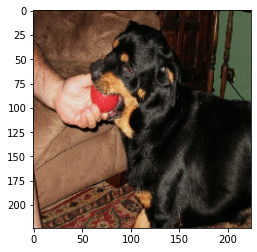

In [ ]:
plt.imshow(batch_imgs.numpy()[1])

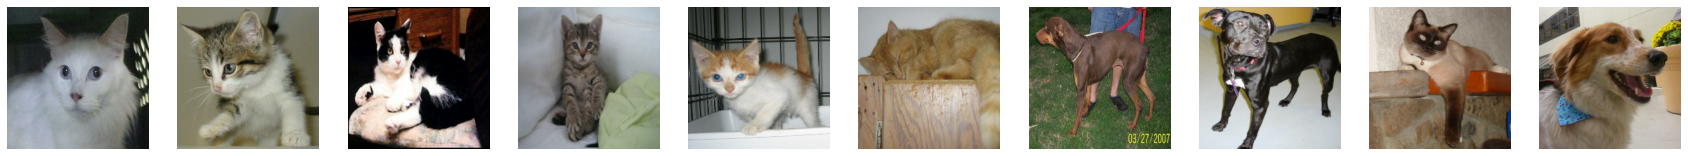

In [ ]:
def show_res(imgs, rows=1, cols=10):
  fig = plt.figure(figsize=(30, 20))
  count = 0
  for row in range(rows):
    for col in range(cols):
      fig.add_subplot(rows, cols, count+1)
      plt.imshow(imgs[count])
      plt.axis("off")
      count += 1

  # fig.suptitle("Correct predictions")
imgs = batch_imgs.numpy()[batch_labels.numpy() == preds_labels]
show_res(imgs)


## Transfer Learning

### Resnet Backbone

In [ ]:
resnet = tf.keras.applications.ResNet50(include_top=False, weights="imagenet", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
resnet_preprocess = tf.keras.applications.resnet50.preprocess_input

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
class MyModel(tf.keras.models.Model):
  def __init__(self, num_classes):
    super(MyModel, self).__init__()
    self.embed = resnet
    # self.embed.trainable=False
    self.gap = tf.keras.layers.GlobalAveragePooling2D()
    self.dropout = tf.keras.layers.Dropout(0.2)
    # self.dense1 = tf.keras.layers.Dense(128, activation="relu")
    self.dense2 = tf.keras.layers.Dense(num_classes)

  def call(self, inputs):
    x = self.embed(inputs, training=False)
    x = self.gap(x)
    x = self.dropout(x)
    # x = self.dense1(x)
    x = self.dense2(x)
    return x

  

In [ ]:
tf.keras.layers.Dense?

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

### Functional API

In [ ]:
# freeze the weights of the pretrained network
resnet.trainable = False
# preprocess_input = tf.keras.applications.resnet50.preprocess_input

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
# inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
# model = MyModel(num_classes=1)
inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = data_augmentation(inputs)
x = resnet_preprocess(x)
x = resnet(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)
# outputs = model(x)

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=["accuracy"])


In [ ]:
model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
179/179 [==============================] - 100s 321ms/step - loss: 0.5960 - accuracy: 0.6735 - val_loss: 0.2081 - val_accuracy: 0.9363
Epoch 2/10
179/179 [==============================] - 64s 309ms/step - loss: 0.2359 - accuracy: 0.9117 - val_loss: 0.1176 - val_accuracy: 0.9672
Epoch 3/10
179/179 [==============================] - 65s 311ms/step - loss: 0.1578 - accuracy: 0.9459 - val_loss: 0.0868 - val_accuracy: 0.9773
Epoch 4/10
179/179 [==============================] - 64s 311ms/step - loss: 0.1326 - accuracy: 0.9506 - val_loss: 0.0705 - val_accuracy: 0.9816
Epoch 5/10
179/179 [==============================] - 64s 311ms/step - loss: 0.1102 - accuracy: 0.9603 - val_loss: 0.0612 - val_accuracy: 0.9851
Epoch 6/10
179/179 [==============================] - 64s 310ms/step - loss: 0.1025 - accuracy: 0.9630 - val_loss: 0.0557 - val_accuracy: 0.9859
Epoch 7/10
179/179 [==============================] - 64s 310ms/step - loss: 0.0952 - accuracy: 0.9634 - val_loss: 0.0503 - val_a

### Subclassing

In [ ]:
# resnet
resnet.trainable = False
model = MyModel(1)
inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = data_augmentation(inputs)
x = resnet_preprocess(x)
x = model(x)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=["accuracy"])


In [ ]:
model.summary()

Model: "my_model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_2 ( multiple                  0         
_________________________________________________________________
dropout_2 (Dropout)          multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  2049      
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
179/179 [==============================] - 67s 308ms/step - loss: 0.5151 - accuracy: 0.7314 - val_loss: 0.1993 - val_accuracy: 0.9337
Epoch 2/10
179/179 [==============================] - 63s 302ms/step - loss: 0.1855 - accuracy: 0.9330 - val_loss: 0.1294 - val_accuracy: 0.9558
Epoch 3/10
179/179 [==============================] - 62s 299ms/step - loss: 0.1287 - accuracy: 0.9544 - val_loss: 0.1042 - val_accuracy: 0.9634
Epoch 4/10
179/179 [==============================] - 62s 298ms/step - loss: 0.1018 - accuracy: 0.9638 - val_loss: 0.0915 - val_accuracy: 0.9666
Epoch 5/10
179/179 [==============================] - 62s 300ms/step - loss: 0.0890 - accuracy: 0.9682 - val_loss: 0.0832 - val_accuracy: 0.9695
Epoch 6/10
179/179 [==============================] - 62s 299ms/step - loss: 0.0827 - accuracy: 0.9705 - val_loss: 0.0777 - val_accuracy: 0.9711
Epoch 7/10
179/179 [==============================] - 62s 300ms/step - loss: 0.0767 - accuracy: 0.9715 - val_loss: 0.0740 - val_ac

### Mobilenet

In [ ]:
mobilenet = tf.keras.applications.MobileNetV2(include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), weights="imagenet")
mobilenet_preprocess = tf.keras.applications.mobilenet_v2.preprocess_input

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
# data augmentation to reduce overfitting
# randomly flip and rotate the images
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

In [ ]:
# freeze the weights of the pretrained network
mobilenet.trainable = False
# preprocess_input = tf.keras.applications.resnet50.preprocess_input

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
# inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
# model = MyModel(num_classes=1)
inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = data_augmentation(inputs)
x = mobilenet_preprocess(x)
x = mobilenet(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model_mobilenet = tf.keras.Model(inputs, outputs)
# outputs = model(x)

model_mobilenet.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=["accuracy"])


In [ ]:
# model.summary()

In [ ]:
model_mobilenet.fit(train_ds, epochs=10, callbacks=[callback], validation_data=val_ds)

Epoch 1/10
179/179 [==============================] - 43s 168ms/step - loss: 0.6113 - accuracy: 0.6684 - val_loss: 0.2519 - val_accuracy: 0.9558
Epoch 2/10
179/179 [==============================] - 37s 162ms/step - loss: 0.2878 - accuracy: 0.9106 - val_loss: 0.1496 - val_accuracy: 0.9726
Epoch 3/10
179/179 [==============================] - 38s 162ms/step - loss: 0.2058 - accuracy: 0.9349 - val_loss: 0.1121 - val_accuracy: 0.9773
Epoch 4/10
179/179 [==============================] - 38s 162ms/step - loss: 0.1578 - accuracy: 0.9509 - val_loss: 0.0918 - val_accuracy: 0.9801
Epoch 5/10
179/179 [==============================] - 37s 161ms/step - loss: 0.1411 - accuracy: 0.9523 - val_loss: 0.0797 - val_accuracy: 0.9822
Epoch 6/10
179/179 [==============================] - 37s 161ms/step - loss: 0.1294 - accuracy: 0.9559 - val_loss: 0.0714 - val_accuracy: 0.9828
Epoch 7/10
179/179 [==============================] - 38s 163ms/step - loss: 0.1230 - accuracy: 0.9559 - val_loss: 0.0651 - val_ac

### Fine Tuning with mobilenet

In [ ]:
mobilenet.trainable = True


In [ ]:
print("Number of layers in the base model: ", len(mobilenet.layers))
fine_tune_at = 100
for layer in mobilenet.layers[:fine_tune_at]:
  layer.trainable = False


Number of layers in the base model:  154


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.RMSprop(lr=0.0001/10),
              metrics=["accuracy"])

In [ ]:
model.summary()

Model: "my_model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_16  multiple                  0         
_________________________________________________________________
dropout_10 (Dropout)         multiple                  0         
_________________________________________________________________
dense_19 (Dense)             multiple                  1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
len(model.trainable_variables)

2

## Evaluation

In [ ]:
model.evaluate(test_ds)

110/110 [==============================] - 22s 198ms/step - loss: 0.0629 - accuracy: 0.9755


[0.06290547549724579, 0.975494384765625]

In [ ]:
model_mobilenet.evaluate(test_ds)

110/110 [==============================] - 10s 93ms/step - loss: 0.0549 - accuracy: 0.9854


[0.05488363653421402, 0.985382616519928]

In [ ]:
model.save("cat_vs_dog")
model_mobilenet.save("cat_vs_dog_mobilenet")

INFO:tensorflow:Assets written to: cat_vs_dog/assets


INFO:tensorflow:Assets written to: cat_vs_dog/assets


INFO:tensorflow:Assets written to: cat_vs_dog_mobilenet/assets


INFO:tensorflow:Assets written to: cat_vs_dog_mobilenet/assets


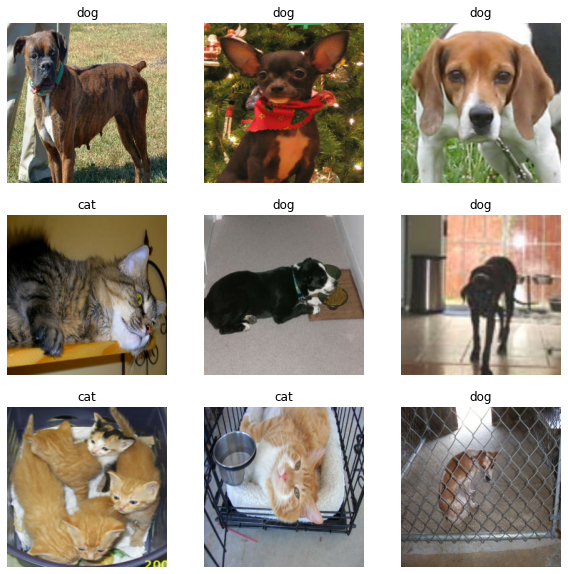

In [ ]:
show_imgs(test_ds)

In [ ]:
model = tf.keras.models.load_model("cat_vs_dog")
model_mobilenet = tf.keras.models.load_model("cat_vs_dog_mobilenet")

Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Labels:
 [1 1 1 0 1 1 0 0 1 1 1 0 0 1 0 0 0 1 0 1 1 0 1 0 0 0 1 1 1 1 1 1 1 0 1 1 1
 1 1 0 1 0 1 1 0 0 1 0 1 1 0 1 0 1 0 0 0 1 1 0 0 1 0 1]


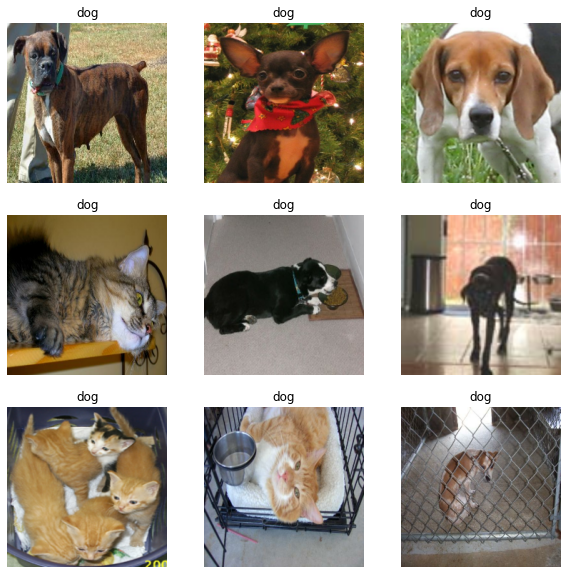

In [ ]:
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)
print("Predictions:\n", predictions.numpy())
print("Labels:\n", label_batch)
class_names = ["cat", "dog"]
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Labels:
 [1 1 1 0 1 1 0 0 1 1 1 0 0 1 0 0 0 1 0 1 1 0 1 0 0 0 1 1 1 1 1 1 1 0 1 1 1
 1 1 0 1 0 1 1 0 0 1 0 1 1 0 1 0 1 0 0 0 1 1 0 0 1 0 1]


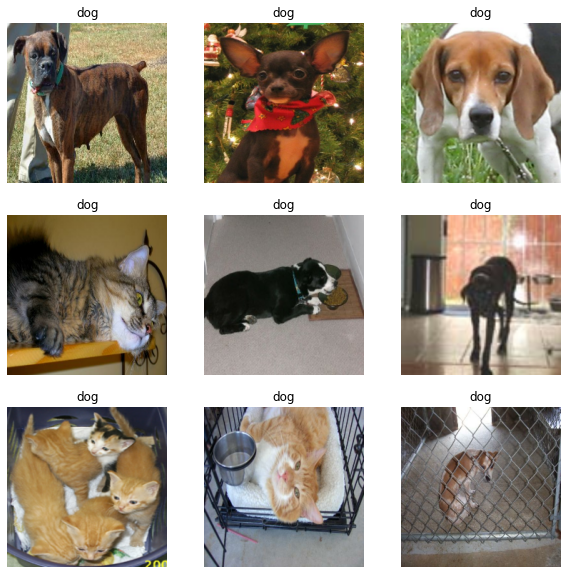

In [ ]:
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model_mobilenet.predict_on_batch(image_batch).flatten()
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)
print("Predictions:\n", predictions.numpy())
print("Labels:\n", label_batch)
class_names = ["cat", "dog"]
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [ ]:
!zip -r /content/cat_vs_dog.zip /content/cat_vs_dog/

  adding: content/cat_vs_dog/ (stored 0%)
  adding: content/cat_vs_dog/variables/ (stored 0%)
  adding: content/cat_vs_dog/variables/variables.index (deflated 78%)
  adding: content/cat_vs_dog/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/cat_vs_dog/saved_model.pb (deflated 93%)
  adding: content/cat_vs_dog/assets/ (stored 0%)


In [ ]:
from google.colab import files
files.download("/content/cat_vs_dog.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Inference Script


In [ ]:
!unzip /content/content.zip

Archive:  /content/content.zip
   creating: content/
   creating: content/cat_vs_dog/
   creating: content/cat_vs_dog/assets/
  inflating: content/cat_vs_dog/saved_model.pb  
   creating: content/cat_vs_dog/variables/
  inflating: content/cat_vs_dog/variables/variables.data-00000-of-00001  
  inflating: content/cat_vs_dog/variables/variables.index  


In [ ]:
ls content/

ls: cannot access 'content/': No such file or directory


In [ ]:
model = tf.keras.models.load_model("content/cat_vs_dog/")

In [ ]:
dog_img.split(".")

['/content/dog', 'png']

In [ ]:

def decode_img(img, png=True):
  # convert the compressed string into a 3d uint8 tensor
  if png:
    img = tf.image.decode_png(img, channels=3)
  else:
    img = tf.image.decode_jpeg(img, channels=3)
  return tf.image.resize(img, [224, 224])

In [ ]:
def process_path(file_path):
  ext = file_path.split(".")[-1]
  img = tf.io.read_file(file_path)
  if ext == "png":
    img = decode_img(img)
  else:
    img = decode_img(img, png=False)
  return img

In [ ]:
def preprocess_img(img_path):
  img = process_path(img_path)
  img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
  img = tf.reshape(img, [1, 224, 224, 3])
  return tf.image.convert_image_dtype(img, dtype=tf.float32)


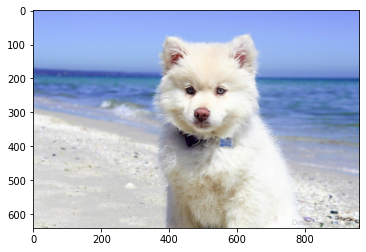

In [ ]:
img_path = "/content/Thinking-of-getting-a-cat.png"
dog_img = "/content/dog.jfif"
# img = preprocess_img
plt.imshow(plt.imread(dog_img))


In [ ]:
img = preprocess_img(dog_img)
img.shape

TensorShape([1, 224, 224, 3])

In [ ]:
class_names = ["cat", "dog"]
pred = model.predict(img).flatten()
pred = tf.nn.sigmoid(pred)
pred = tf.where(pred < 0.5, 0, 1)
print(class_names[pred.numpy()[0]])

cat


Our model wrongly predicts this dog as a cat!

In [ ]:
def make_prediction(img_path: str) -> str:
    img = preprocess_img(img_path)
    class_names = ["cat", "dog"]
    pred = model.predict(img).flatten()
    pred = tf.nn.sigmoid(pred)
    pred = tf.where(pred < 0.5, 0, 1)
    pred = class_names[pred.numpy()[0]]
    return pred
  
make_prediction(dog_img)

'cat'